# Training an ANN to represent the gravity acceleration produced by a mascon
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body represented by a mascon model. 

The loss is defined on the prediction accuracy of the gravitational acceleration field.

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter
 conda activate geodesyann
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```


In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

print("Name: ", mascon_name)
print("Number of points: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Eros
Number of points:  39554
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.06402954459190369


<IPython.core.display.Javascript object>


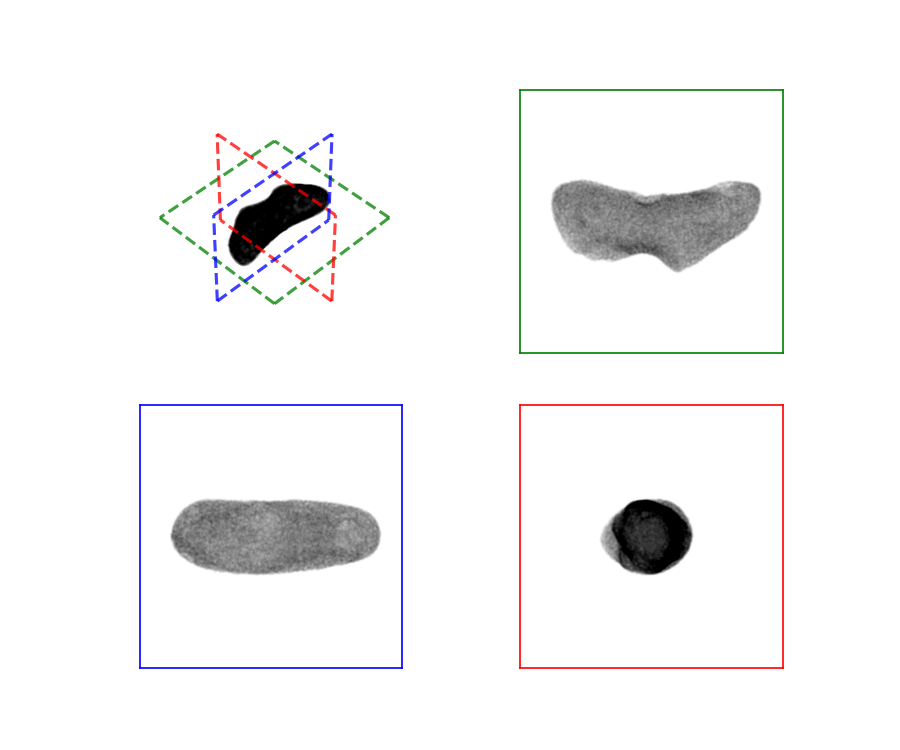

In [3]:
gravann.plot_mascon(mascon_points, mascon_masses)

# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [4]:
# Encoding choosen
encoding = gravann.direct_encoding()
model = gravann.init_network(encoding, n_neurons=100, model_type="siren")

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init some loss trend indicators
weighted_average = deque([], maxlen=20)

In [5]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
model.load_state_dict(torch.load("results/run_27_11_2020_ACC_siren/Eros.pk/LR=0.0001_loss=normalized_L1_loss_encoding=direct_encoding_batch_size=1000_target_sample=spherical_activation=Sigmoid/model.mdl"))
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)


## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function we plot via rejection sampling. 

Sampling points...: 2561it [00:09, 263.54it/s]                                                                         


<IPython.core.display.Javascript object>


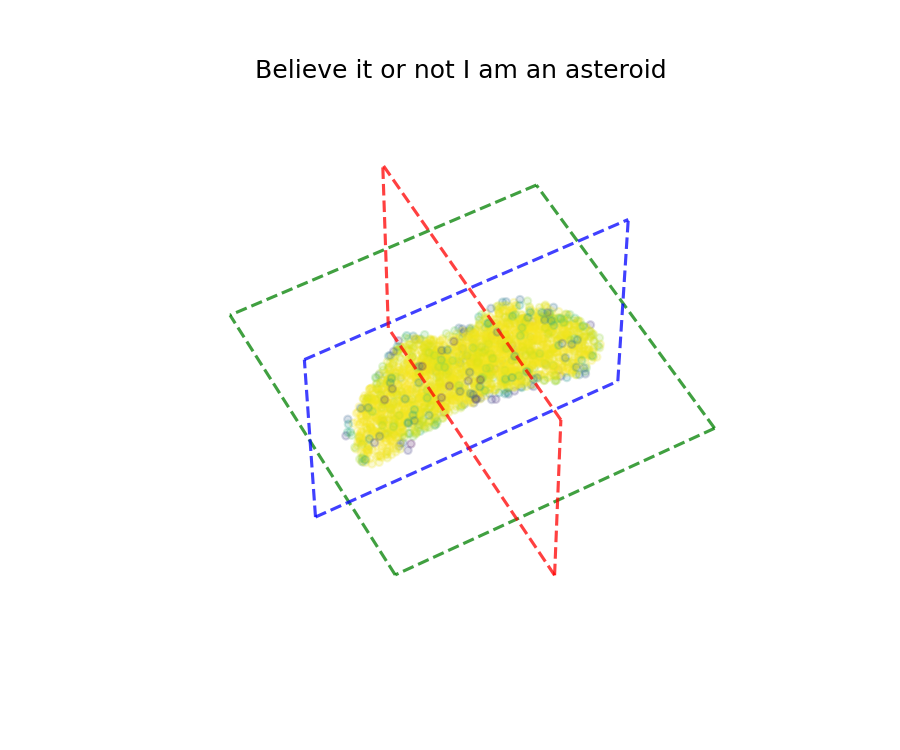

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [26]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=1)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [23]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Here we set some hyperparameters
N_mc_points = 30000
batch_size = 100

# Here we set the loss
#loss_fn = gravann.mse_loss
loss_fn = gravann.normalized_L1_loss

# Here we set the choosen Integration method
#mc_method = gravann.ACC_ld
mc_method = gravann.ACC_trap

# Here we set the method to sample the target points
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Eros.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 5000, min_lr = 5e-6,verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.5, step_size_up=250, mode="exp_range", gamma = .997)

In [24]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
torch.cuda.empty_cache()
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
    labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(target_points, model, encoding, N=N_mc_points)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_mc_points*batch_size) // 1000)
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

It=0	 loss=6.278e-02	  weighted_average=5.373e-02	  c=2.998e+01
It=25	 loss=6.580e-02	  weighted_average=1.729e-01	  c=1.117e+01
It=50	 loss=4.764e-02	  weighted_average=8.479e-02	  c=1.144e+01
It=75	 loss=2.902e-02	  weighted_average=3.954e-02	  c=1.007e+01
It=100	 loss=2.851e-02	  weighted_average=3.044e-02	  c=9.487e+00
It=125	 loss=2.126e-01	  weighted_average=4.677e-01	  c=7.664e+00
It=150	 loss=5.020e-02	  weighted_average=6.383e-02	  c=8.059e+00
It=175	 loss=5.094e-02	  weighted_average=1.450e-01	  c=7.620e+00
It=200	 loss=2.806e-02	  weighted_average=3.418e-02	  c=8.250e+00
It=225	 loss=3.488e-02	  weighted_average=2.813e-02	  c=8.010e+00
It=250	 loss=3.065e-02	  weighted_average=4.083e-02	  c=8.923e+00
It=275	 loss=1.505e-02	  weighted_average=1.818e-02	  c=8.235e+00
It=300	 loss=3.185e-02	  weighted_average=2.353e-02	  c=8.243e+00
It=325	 loss=2.864e-02	  weighted_average=1.975e-02	  c=8.412e+00
It=350	 loss=2.794e-02	  weighted_average=3.068e-02	  c=8.451e+00
It=375	 loss=1.

KeyboardInterrupt: 

Sampling points...: 1627it [00:02, 666.45it/s]                                                                         


<IPython.core.display.Javascript object>


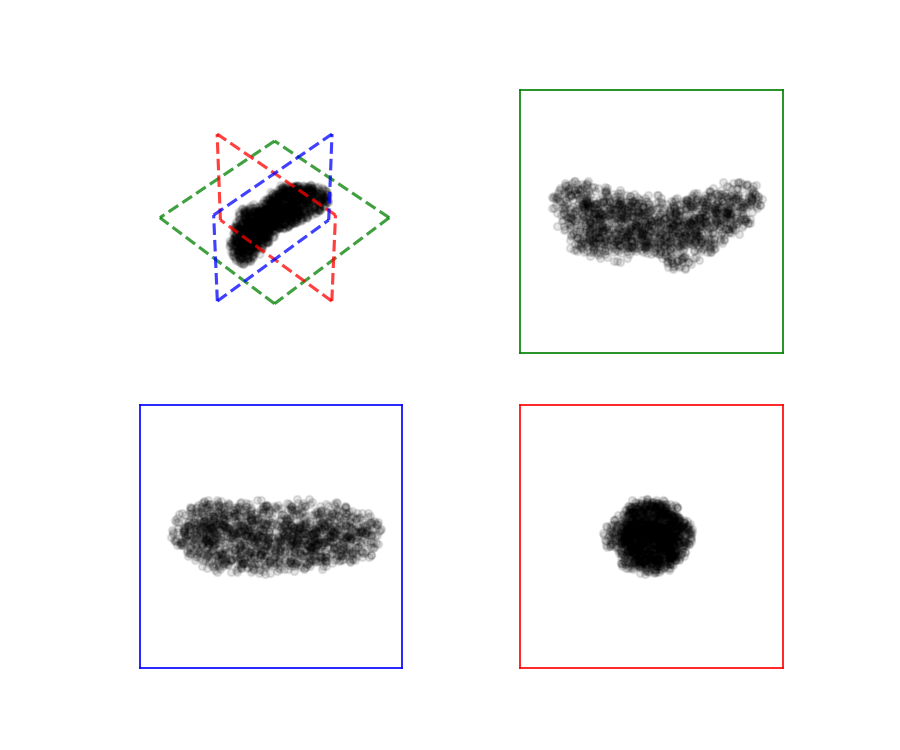

In [27]:
# Rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

In [ ]:
# Plot the loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

In [ ]:
# Rejection plot overlayed with the mascon
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=2500, heatmap=True)

In [ ]:
# Generating a mesh out of the model
gravann.plot_model_mesh(model,encoding,rho_threshold=c.cpu().detach().numpy()*1e-2) 

In [ ]:
# Compute c 
#target_points = targets_point_sampler()
#labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
#predicted = mc_method(target_points, model, encoding, N=N_mc_points)
#c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)

In [ ]:
# Computes the Validation table
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Bennu_lp.pk", N=5000, N_integration=500000, batch_size=32, progressbar=True)

In [ ]:
# Compute the acceleration plot
gravann.plot_model_mascon_acceleration("3dmeshes/Bennu.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False)

#### Saving the model

In [ ]:
# Uncomment to save to models/cluster_xxxx
#torch.save(model.state_dict(), "models/siren_acc_bennu.mdl")

In [59]:
from scipy.spatial.transform import Rotation as rotation
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.colors as colors
def plot_potential_contours(model, encoding, heatmap=False, section=np.array([0, 0, 1]), N=100, save_path=None, offset=0., c=1.):
    # Builds a 2D grid
    e1, e2 = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
    e1 = np.reshape(e1, (-1,))
    e2 = np.reshape(e2, (-1,))
    zeros = np.zeros(N**2)
    p = np.zeros((N**2, 3))
    
    # Opens the figure
    fig = plt.figure(figsize=(9,3))
    cmap = mpl.cm.inferno

    # z-axis
    ax = fig.add_subplot(131)
    p[:, 0] = e1
    p[:, 1] = e2
    p[:, 2] = zeros
    # ... and compute them
    target_points = encoding(torch.tensor(p, dtype=torch.float32))
    potential = gravann.U_trap_opt(target_points, model, encoding=encoding, N=10000, verbose=False, noise=1e-5, sample_points=None, h=None, domain=None)
    Z = potential.reshape((N, N)).cpu().detach().numpy()
    X, Y = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
    ax.contourf(X, Y, Z, cmap=cmap, levels=10)
    mp = mascon_points.cpu().detach().numpy()
    ax.plot(mp[:,0], mp[:,1], '.', c='k', alpha=0.02)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_aspect('equal', 'box')
    ax.spines['left'].set_color('green')
    ax.spines['right'].set_color('green')
    ax.spines['top'].set_color('green')
    ax.spines['bottom'].set_color('green')
    
    # y-axis
    ax_y = fig.add_subplot(132)
    p[:, 0] = e1
    p[:, 1] = zeros
    p[:, 2] = e2
    # ... and compute them
    target_points = encoding(torch.tensor(p, dtype=torch.float32))
    potential = gravann.U_trap_opt(target_points, model, encoding=encoding, N=10000, verbose=False, noise=1e-5, sample_points=None, h=None, domain=None)
    Z = potential.reshape((N, N)).cpu().detach().numpy()
    X, Y = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
    ax_y.contourf(X, Y, Z, cmap=cmap, levels=10)
    mp = mascon_points.cpu().detach().numpy()
    ax_y.plot(mp[:,0], mp[:,2], '.', c='k', alpha=0.02)
    ax_y.set_xticks([])
    ax_y.set_yticks([])
    ax_y.set_xlim([-2, 2])
    ax_y.set_ylim([-2, 2])
    ax_y.set_aspect('equal', 'box')
    ax_y.spines['left'].set_color('blue')
    ax_y.spines['right'].set_color('blue')
    ax_y.spines['top'].set_color('blue')
    ax_y.spines['bottom'].set_color('blue')
    
    # x-axis
    ax_x = fig.add_subplot(133)
    p[:, 0] = zeros
    p[:, 1] = e1
    p[:, 2] = e2
    # ... and compute them
    target_points = encoding(torch.tensor(p, dtype=torch.float32))
    potential = gravann.U_trap_opt(target_points, model, encoding=encoding, N=10000, verbose=False, noise=1e-5, sample_points=None, h=None, domain=None)
    Z = potential.reshape((N, N)).cpu().detach().numpy()
    X, Y = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
    ax_x.contourf(X, Y, Z, cmap=cmap, levels=10)
    mp = mascon_points.cpu().detach().numpy()
    ax_x.plot(mp[:,1], mp[:,2], '.', c='k', alpha=0.02)
    ax_x.set_xticks([])
    ax_x.set_yticks([])
    ax_x.set_xlim([-2, 2])
    ax_x.set_ylim([-2, 2])
    ax_x.set_aspect('equal', 'box')
    ax_x.spines['left'].set_color('red')
    ax_x.spines['right'].set_color('red')
    ax_x.spines['top'].set_color('red')
    ax_x.spines['bottom'].set_color('red')
    

<IPython.core.display.Javascript object>


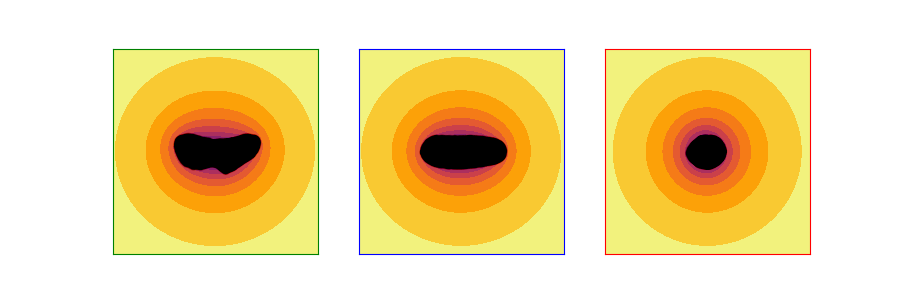

In [60]:
Z =plot_potential_contours(model, encoding, heatmap=False, section=np.array([0, 0, 1]), N=100, save_path=None, offset=0.)

In [59]:
Z

array([[-0.0810497 , -0.0818062 , -0.08256546, ..., -0.08235299,
        -0.08159557, -0.080841  ],
       [-0.0819637 , -0.08274572, -0.08353095, ..., -0.08330941,
        -0.0825263 , -0.08174656],
       [-0.08289289, -0.08370142, -0.08451373, ..., -0.08428243,
        -0.08347256, -0.08266664],
       ...,
       [-0.08379523, -0.08461207, -0.08543058, ..., -0.08504426,
        -0.08424541, -0.08344731],
       [-0.08281093, -0.08359919, -0.08438866, ..., -0.08400817,
        -0.08323708, -0.08246641],
       [-0.0818451 , -0.08260608, -0.08336785, ..., -0.08299384,
        -0.08224923, -0.08150476]], dtype=float32)

In [56]:
Z

array([[-0.08104885, -0.08180535, -0.08256461, ..., -0.08235219,
        -0.08159478, -0.08084023],
       [-0.08196285, -0.08274484, -0.08353008, ..., -0.08330861,
        -0.08252551, -0.08174577],
       [-0.08289202, -0.08370055, -0.08451286, ..., -0.08428161,
        -0.08347175, -0.08266583],
       ...,
       [-0.08379427, -0.08461109, -0.08542958, ..., -0.08504351,
        -0.08424466, -0.08344658],
       [-0.08280997, -0.08359821, -0.08438767, ..., -0.08400743,
        -0.08323634, -0.08246568],
       [-0.08184417, -0.08260512, -0.08336688, ..., -0.08299309,
        -0.0822485 , -0.08150403]], dtype=float32)

In [77]:
torch.cuda.empty_cache()
plt.close('all')